In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics import normalized_mutual_info_score

In [2]:
data_s3 = np.loadtxt('../Data_USL/s3.txt')
full_agg = np.loadtxt('../Data_USL/Aggregation.txt')
data_agg = full_agg[:,[0,1]] 
true_agg = full_agg[:,2]
true_s3 = np.loadtxt('../Data_USL/s3-true_vals.txt')
data_agg.shape

(788, 2)

# Density Peak

In [3]:
def dbscan(data,d_c,n_clusters):
    # data -> array of points
    # d_c -> cutoff distance
    # n_clusters -> number of clusters. Choose 15 for s3 and 7 for Aggregation.
    n_points = data.shape[0]
    dist_mat = distance.cdist(data,data,metric='euclidean')
    density = np.sum(np.exp(- np.square(dist_mat/d_c)), axis=1)
    labels = np.full(n_points,-1)
    rem_assign = []
    
    dist_vec = np.zeros_like(density)
    idx = np.zeros_like(density, dtype='int')
    
    max_density = np.argmax(density)
    max_dist = np.max(dist_mat)
    
    for i in range(n_points):
        if i == max_density:
            idx[i] = np.argmax(dist_mat[i])
            dist_vec[i] = dist_mat[i,idx[i]]
            continue
        idx[i] = np.argmin(dist_mat[i] + (density <= density[i])*max_dist)
        dist_vec[i] = dist_mat[i,idx[i]]
     
    idx_max_gamma = np.argsort(np.multiply(density,dist_vec))[::-1]
    
    centroid_idx = idx_max_gamma[:n_clusters]
    centroid_positions = data[centroid_idx]
    
    for i in range(centroid_idx.shape[0]):
        labels[centroid_idx[i]] = i
    
    for i in range(n_points):
        if labels[i] != -1:
            continue
        neigh_idx = idx[i]
        rem_assign = [i,]
        while (labels[neigh_idx]) == -1:
            rem_assign.append(neigh_idx)
            neigh_idx = idx[neigh_idx]
        cluster_idx = labels[neigh_idx]
        for j in rem_assign:
            labels[j] = cluster_idx
            
    dist_sq_mat = distance.cdist(data, centroid_positions, metric='sqeuclidean') 
    dist_sq_min = np.array([np.min(dist_sq_mat, axis = 1) ]) 
    total_loss = dist_sq_min.sum() 
        
    return density,dist_vec,labels,total_loss,centroid_positions

In [4]:
def cluster_plot(data,labels,centroid_positions,n_clusters):
    plt.figure(figsize=(7,5))
    for i in range(n_clusters):
        array = data[labels==i]
        plt.scatter(array[:,0], array[:,1], s=4)
    plt.scatter(centroid_positions[:,0],centroid_positions[:,1],s=12,c='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()    

## S3 - Density Peak

In [5]:
%%time
density_s3, dist_vec_s3, labels_s3, loss_s3, centroid_positions_s3 = dbscan(data_s3,d_c=57500,n_clusters=15)

CPU times: user 1.19 s, sys: 784 ms, total: 1.98 s
Wall time: 2 s


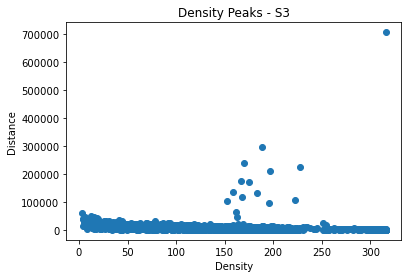

In [6]:
plt.title("Density Peaks - S3")
plt.xlabel('Density')
plt.ylabel('Distance')
plt.scatter(density_s3,dist_vec_s3)

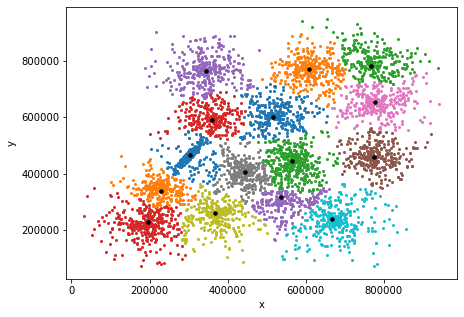

In [7]:
cluster_plot(data_s3,labels_s3,centroid_positions_s3,n_clusters=15)

## Aggregation - Density Peak

In [8]:
%%time
density_agg, dist_vec_agg, labels_agg, loss_agg, centroid_positions_agg = dbscan(data_agg,2.5,7)

CPU times: user 53.7 ms, sys: 11.9 ms, total: 65.5 ms
Wall time: 64.6 ms


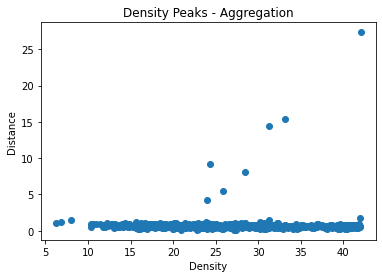

In [9]:
plt.title("Density Peaks - Aggregation")
plt.xlabel('Density')
plt.ylabel('Distance')
plt.scatter(density_agg,dist_vec_agg)

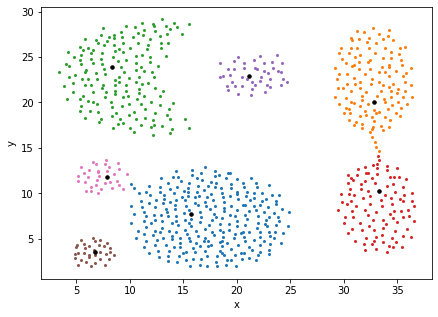

In [10]:
cluster_plot(data_agg,labels_agg,centroid_positions_agg,n_clusters=7)

# K-Means

In [11]:
def kmeans_pp_init(data, k):
    centroids = data[np.random.choice(data.shape[0],1,replace=False)]
    kmpp_init_centroids = np.empty((k, data.shape[1]))
    kmpp_init_centroids[0] = centroids
    for i in range(1,k):
        dist_sq = distance.cdist(data, centroids, metric='sqeuclidean')
        probability = np.squeeze(dist_sq/np.sum(dist_sq))
        new_centroid = data[np.random.choice(data.shape[0], 1, replace=False, p=probability)]
        
        if new_centroid in kmpp_init_centroids:
            i = i - 1 # choose new centroid and repeat this iteration
        else:
            kmpp_init_centroids[i] = new_centroid.copy()
            centroids = new_centroid.copy()
        
    return kmpp_init_centroids


def kmeans(data, k, max_iter=300):
    # data -> array of data points
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    
    # Here, we initialize differently for KMeans++
    #tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
    #init_positions = tmp_arr.copy()
    init_positions = kmeans_pp_init(data,k) 
        
    for i in range(max_iter):
        dist_sq = distance.cdist(data,init_positions,metric='sqeuclidean')
        dist_sq_min = np.array([np.min(dist_sq, axis=1)])
        labels = np.argmin(dist_sq, axis=1)
        total_loss = dist_sq_min.sum()
        flag = False
        
        for j in range(k):
            if len(data[labels==j]) == 0:
                flag = True
        
        if flag == True:
            tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
            init_positions = tmp_arr.copy()
            continue
        
        new_positions = np.array([data[labels==l].mean(axis=0) for l in range(k)])    
                
        if np.all(init_positions == new_positions):
            break
        
        init_positions = new_positions
        
    #print("Reached Maximum Number of Iterations")
    return total_loss, i, labels, new_positions

In [12]:
def cluster_plot_kmeans(data,k,labels,centroid_positions):
    n_points = data.shape[0]
    plt.figure(figsize=(7,5))
    for i in range(k):
        array = data[labels==i]
        plt.scatter(array[:,0],array[:,1],s=4)
    plt.scatter(centroid_positions[:,0],centroid_positions[:,1],s=12,c='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## S3 - K-Means

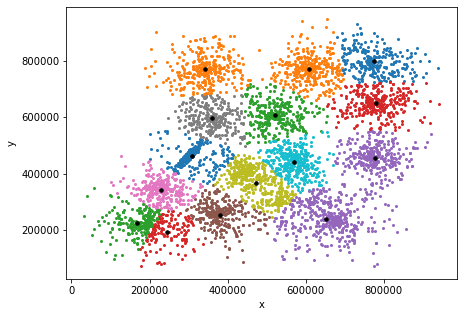

CPU times: user 600 ms, sys: 4.46 ms, total: 605 ms
Wall time: 600 ms


In [13]:
%%time
*_, labels_s3_k, centroid_positions_s3_k = kmeans(data_s3,15)
cluster_plot_kmeans(data_s3,15,labels_s3_k,centroid_positions_s3_k)

## Aggregation - K-Means

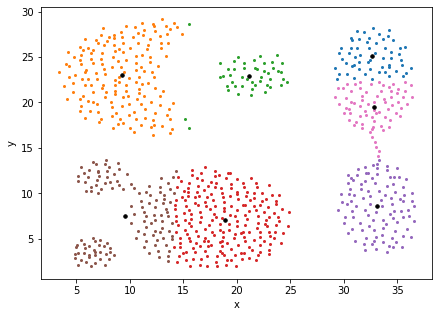

CPU times: user 479 ms, sys: 3.46 ms, total: 482 ms
Wall time: 477 ms


In [14]:
%%time
*_, labels_agg_k, centroid_positions_agg_k = kmeans(data_agg,7)
cluster_plot_kmeans(data_agg,15,labels_agg_k,centroid_positions_agg_k)

# F-Ratio Comparison

In [15]:
def fratio(data, labels, centroid_positions, n_clusters):
    ssw = np.sum(np.square(data - centroid_positions[labels]))
    tmp = 0.0
    for i in range(n_clusters):
        tmp += np.sum(labels==i) * np.sum(np.square(centroid_positions[i] - np.mean(data, axis=0)))
    ssb = tmp
    f_ratio_val = n_clusters*ssw/ssb
    return f_ratio_val

In [16]:
fr_s3_dp = fratio(data_s3,labels_s3,centroid_positions_s3,n_clusters=15)
fr_s3_km = fratio(data_s3,labels_s3_k,centroid_positions_s3_k,n_clusters=15)

print("F-Ratio: Density Peaks: S3 = ", fr_s3_dp)
print("F-Ratio: K-Means: S3 = ", fr_s3_km)

F-Ratio: Density Peaks: S3 =  0.7640503274998506
F-Ratio: K-Means: S3 =  0.7516191146161149


In [17]:
fr_agg_dp = fratio(data_agg,labels_agg,centroid_positions_agg,n_clusters=7)
fr_agg_km = fratio(data_agg,labels_agg_k,centroid_positions_agg_k,n_clusters=7)

print("F-Ratio: Density Peaks: agg = ", fr_agg_dp)
print("F-Ratio: K-Means: agg = ", fr_agg_km)

F-Ratio: Density Peaks: agg =  0.8639409727670924
F-Ratio: K-Means: agg =  0.7056657833676186


# Normalized Mutual Information

In [27]:
def nmi(true_dataset, result):
    res_vals, res_counts = np.unique(result, return_counts=True)
    true_vals, true_counts = np.unique(true_dataset, return_counts=True)
    p_r = res_counts / result.shape[0]
    p_t = true_counts / true_dataset.shape[0]
    
    H_r = - (p_r*np.log(p_r)).sum()
    H_t = - (p_t*np.log(p_t)).sum()

    cnt = np.zeros((true_vals.shape[0], res_vals.shape[0]))
    for i in range(true_vals.shape[0]):
        for j in range(res_vals.shape[0]):
            cnt[i][j] += (result[true_dataset==true_vals[i]]==res_vals[j]).sum()
    
    p = cnt / result.shape[0]
    MI = 0.0
    for i in range(true_vals.shape[0]):
        for j in range(res_vals.shape[0]):
            if p[i,j] != 0:
                MI += p[i,j] * np.log(p[i,j]/(p_t[i]*p_r[j]))
                
    MI = 2.*MI/(H_r + H_t)
    return MI 

## NMI - S3

In [30]:
print("S3: DBSCAN - My Implementation:",nmi(true_s3, labels_s3))
print("S3: DBSCAN - SKLEARN:",normalized_mutual_info_score(true_s3, labels_s3))

S3: DBSCAN - My Implementation: 0.785441614983089
S3: DBSCAN - SKLEARN: 0.7854416149830893


In [31]:
print("S3: K-Means - My Implementation:",nmi(true_s3, labels_s3_k))
print("S3: K-Means - SKLEARN:",normalized_mutual_info_score(true_s3, labels_s3_k))

S3: K-Means - My Implementation: 0.7787531429877623
S3: K-Means - SKLEARN: 0.7787531429877622


## NMI - Aggregate

In [32]:
print("Agg: DBSCAN - My Implementation:",nmi(true_agg, labels_agg))
print("Agg: DBSCAN - SKLEARN:",normalized_mutual_info_score(true_agg, labels_agg))

Agg: DBSCAN - My Implementation: 1.0000000000000002
Agg: DBSCAN - SKLEARN: 1.0


In [33]:
print("Agg: K-Means - My Implementation:",nmi(true_agg, labels_agg_k))
print("Agg: K-Means - SKLEARN:",normalized_mutual_info_score(true_agg, labels_agg_k))

Agg: K-Means - My Implementation: 0.8528936322994107
Agg: K-Means - SKLEARN: 0.8528936322994107
